<h1>Tutorial 4: Pipeline</h1>

<h2>Overview</h2>

In this tutorial, we will talk about the following:

* Loading data into Pipeline
    * Using tf.data.Dataset
    * Using torch.Dataloader
    * Using FastEstimator dataset
* Getting results in Pipeline
* How to use operators in Pipeline
    * Basic concepts about operators
    * Univariate and Multivariate operators
    * Customized operators
    * Load operators into Pipeline and visualize results

In deep learning, data preprocessing is a way of converting data from the raw form to a much more usable or desired form. It is one crucial step in the model training as it directly affects the ability of model to learn. <br>
`Pipeline` API operates by enabling such tasks in efficient manner. It takes care of extracting data from the disk and preprocessing before feeding it to the model. `Pipeline` operations usually happen on CPU.

<h2>Loading data in Pipeline</h2>

In tutorial 2, we demonstrated the different types of datasets. We will see how datasets can be loaded in the `Pipeline` and various operations can be applied to the data. `fe.Pipeline` handles three different type of datasets,
* tf.data.Dataset
* torch.data.Dataloader
* fe.dataset

Let's create a sample datasets `tf.data.Dataset` and `torch.data.Dataloader` from numpy array and we will load them into `Pipeline`<br>

In [1]:
import numpy as np

# sample numpy array to later create datasets from them
train_data = np.random.sample((100,2)) 

<h3>Using tf.data.Dataset</h3>

In [2]:
import fastestimator as fe
import tensorflow as tf

# create tf.data.Datasets from sample data
dataset_tf = tf.data.Dataset.from_tensor_slices(train_data)
dataset_tf = dataset_tf.batch(4)

# load data into pipeline
pipeline_tf = fe.Pipeline(dataset_tf)

<h3>Using torch.data.Dataloader</h3>

In [3]:
import torch
from torch.utils import data

# create torch.data.Dataloader from sample data
dataset_torch = data.TensorDataset(torch.Tensor(train_data))
dataloader_torch = data.DataLoader(dataset_torch, batch_size=4)

# load dataloader instance into pipeline
pipeline_torch = fe.Pipeline(dataloader_torch)

<h3>Using FastEstimator Dataset</h3>

Next, we will see how to use one of the Fastestimator Dataset in the `Pipeline`. We will create `fe.dataset.NumpyDataset` and load it into pipeline. As we saw in tutorial 2, `NumpyDataset` takes dictionary with keys for <b>Input data</b> and <b>Ground truth label</b>.

In [4]:
from fastestimator.dataset.numpy_dataset import NumpyDataset

x_train, y_train = (np.random.sample((100, 2)), np.random.sample((100, 1)))
x_eval, y_eval = (np.random.sample((100, 2)), np.random.sample((100, 1)))

# create NumpyDataset from the sample data
train_data = NumpyDataset({"x": x_train, "y": y_train})
eval_data = NumpyDataset({"x": x_eval, "y": y_eval})

pipeline_fe = fe.Pipeline(train_data=train_data, eval_data=eval_data, batch_size=1)

<h2>Getting results in Pipeline</h2>

After loading the data or performing preprocessing tasks, you might want to inspect the data in the `Pipeline` and ensure the output of the `Pipeline` is as you expected. `fe.Pipeline.get_results` provides this feature and is built to access such data in the `Pipeline`.

In [5]:
pipeline_tf.get_results(num_steps=2)

[<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
 array([[0.82265336, 0.1870217 ],
        [0.60060343, 0.61630385],
        [0.51599405, 0.32319161],
        [0.03101096, 0.22400229]])>,
 <tf.Tensor: shape=(4, 2), dtype=float64, numpy=
 array([[0.07499524, 0.00147919],
        [0.27797139, 0.91683221],
        [0.12748695, 0.57718975],
        [0.7419977 , 0.33204789]])>]

<h2>How to use operators in Pipeline</h2>

In tutorial 3, we learned about the `Operators` and their structures. They are used in FastEstimator for constructing workflow graphs. Here we will talk about Numpy Operator (NumpyOp) and how to use them in `Pipeline`.

`NumpyOp` is the building block of the `Pipeline` and inherits base class `Op`. It performs preprocessing and augmentation tasks on non-Tensor data. With the list of `NumpyOp`, preprocessing tasks become considerably easier in just few lines of code. Many of the augmentation operations leverages the image augmentation library [albumentations](https://github.com/albumentations-team/albumentations). <br>
`NumpyOp` can be further classified in three main classes:
   * Univariate Ops
   * Multivariate Ops
   * Meta Ops
   
In addition to that, we can customize the `NumpyOp` to perform our own operations on the data. Inheriting `fe.op.numpyop` we can create custom `NumpyOp` and use it in `Pipeline`.<br>
In this tutorial, we will learn about Univariate, Multivariate and Custom Ops. We will discuss Meta Ops in the advanced tutorial of the `Pipeline`.

To demonstrate use of operators, we will first load Fashion MNIST dataset in the Pipeline and then will define list of operators for preprocessing data. We will then visualize `Pipeline` Inputs and Outputs.

In [6]:
from fastestimator.dataset.data import mnist

mnist_train, mnist_eval = mnist.load_data()

<h3>Univariate Ops</h3>

Univariate operators perform the same operation for all features. It takes single/multiple input(s) and return single/multiple output(s). For example, `Minmax` is an univariate operator, no matter what feature it is it will perform<br>
(data - min) / (max - min)<br>

In [7]:
from fastestimator.op.numpyop.univariate import Minmax

minmax_op = Minmax(inputs="x", outputs="x_out")

<h3>Multivariate Ops</h3>

Multivariate operaters perform different operations simultaneously based on the nature of features. For example, for input data it will change both input change as well as bounding box or masks at the same time.

We will define Rotate operator that will rotate the images 180 degrees.

In [8]:
from fastestimator.op.numpyop.multivariate import Rotate

rotation_op = Rotate(image_in="x_out", image_out="x_out", limit=180)

<h3>Custom NumpyOp</h3>

Let's create custom Numpy operator that add random noise to the input images.

In [9]:
from fastestimator.op.numpyop import NumpyOp

class AddRandomNoise(NumpyOp):
    def forward(self, data, state):
        # generate noise array with 0 mean and 0.1 standard deviation
        noise = np.random.normal(0, 0.1, data.shape)
        data = data + noise
        return data
    
random_noise_op = AddRandomNoise(inputs="x_out", outputs="x_out")

<h3>Load operators in Pipeline and visualize results</h3>

Now, We will add the list of operaters, that we defined earlier, in the `Pipeline`. 

In [10]:
pipeline = fe.Pipeline(train_data=mnist_train,
                       eval_data=mnist_eval,
                       ops=[minmax_op, rotation_op, random_noise_op],
                      batch_size=2)

Let's get the `Pipeline` results and visualize the input and output images

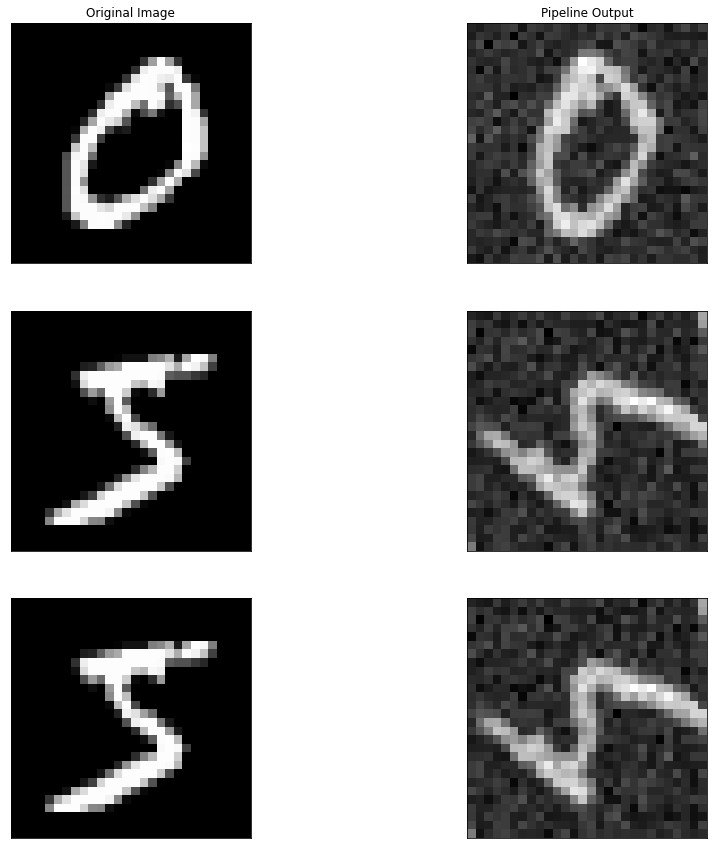

In [11]:
import matplotlib.pyplot as plt

sample_num = 3

# get the pipeline results
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]

# define subplots 
fig, axs = plt.subplots(sample_num, 2, figsize=(15,15))

axs[0,0].set_title("Original Image")
axs[0,1].set_title("Pipeline Output")

plt.setp(axs, xticks=[], yticks=[])

# iterate over sample to plot the results
for i, j in enumerate(np.random.randint(low=0, high=2, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j]
    axs[i,1].imshow(img_out, cmap="gray")